In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


PREFIX='a video of '
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
        "a person riding a bicycle",
        "a certain number of persons fighting",
        "a group of persons playing",
        "a person running",
        "a person lying in the floor",
        "a person chasing other person",
        "a person jumping",
        "a person falling",
        "a person guiding other person",
        "a person stealing other person",
        "a person throwing trash in the floor",
        "a person tripping",
        "a person stealing other person's pocket",
    ]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}
threshold = 51
answer_use=True
stored = False

In [3]:
incorrect=[]
all=[]
def selection_events(events_score, events_answer, verbose=False):
    events_score.pop(PREFIX+normal_prompt)
    # Step 1: Find the maximum score
    max_score = max(events_score.values())
    # Step 2: Filter events that have the max score
    if answer_use:
        top_events = [event for event, score in events_score.items() if score == max_score and events_answer[event] == "Yes"]
    else:
        top_events = [event for event, score in events_score.items() if score == max_score]
    # Result
    if max_score<threshold or len(top_events)==0:
        return [PREFIX+normal_prompt]
    if verbose:
        print("Max score:", max_score)
        print("Events with max score:", top_events)
    return top_events


def check_class(prompts, events, verbose=False):
    if verbose:
        print('Starting\n')
    if prompts== "":
        return [PREFIX+normal_prompt]
    events_score=dict()
    events_answer=dict()
    for j in range(len(events)):
        # Extract "Yes" and "100" using capturing groups
        pattern = r'Answer:\s*(?:\[)?(.*?)(?:\])?\nScore:\s*(?:\[)?(\d+)(?:\])?'
        #print('Prompt:',prompts[i], '\nPredicted:',events[i],'\n')
        match = re.search(pattern, prompts[j])
        if match:
            answer = match.group(1)  # "Yes"
            score = int(match.group(2))  # 100 (converted to integer)
            events_score[events[j]] = score
            events_answer[events[j]] = answer
            #print(f'{j} Event:{events[j]}')
            if verbose:
                print(f"Answer: {answer}, Score: {score}, Event: {events[j]}\n")
    selected_events = selection_events(events_score, events_answer)
    if verbose:
        print(f'Returning {selected_events}\n\n')
    return selected_events
order = [
    "Riding",
    "Playing", 
    "Guiding", 
    "Pickpockering",# Finish specific class events
    "Stealing",
    "Jumping",
    "Tripping",
    "Chasing",
    "Falling",
    "Lying",
    "Littering",
    "Running",
    "Fighting",
]

def reduce_to_one(selected_events):
    for i in range(len(order)):
        if events_description[order[i]] in selected_events:
            return [events_description[order[i]]]
        
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    #prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array)
    count=0
    for i in range(len(prompts)):
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        #pred_class = predicted_events[i]
        # Get ground truth
        #print(pred_class)
        selected_events=check_class(prompts[i], predicted_events[i])
        if event not in selected_events and is_anomaly == 1:
            incorrect.append((event,prompts[i], predicted_events[i]))
        all.append((true_class,prompts[i], predicted_events[i]))
        if true_class in selected_events:
            count+=1
        print(f'{true_class} - {selected_events}')
        if len(selected_events) > 1:
            selected_events=reduce_to_one(selected_events)
        for pred_class in selected_events:
            # Convert to indices (skip if class not recognized)
            true_idx = class_to_idx.get(true_class, -1)
            pred_idx = class_to_idx.get(pred_class, -1)
            
            if true_idx != -1 and pred_idx != -1:
                cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    return tp, fp, fn, tn, cm,count

rute_stored='/home/ubuntu/Tesis/Storage/M4MulticlassNMS'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
all_prompts = []
all_description = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
count=0
for file in files:
    #print(file)
    name= file.split('_CLIP_')[0]
    mode=file.split('_CLIP_')[1][0]
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    predicted_events=info_stored[1]
    #print(predicted_events)
    prompts=info_stored[2]
    all_prompts += list(prompts)
    all_description+= list(predicted_events)
    prompts_number += len(prompts)
    tp, fp, fn, tn, cm, sum= check_precision(frames_number, name, predicted_events, event, description, prompts, mode)
    cm_sum += cm
    count+= sum
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
print(f'Total prompts: {prompts_number}')

a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a normal view (persons walking or standing)']
a video of a normal view (persons walking or standing) - ['a video of a 

In [4]:
print(df)


        Name                                            Event Mode  TP   FP  \
0    4_089_1                      a video of a person falling    3   9    3   
1    1_092_1                      a video of a person jumping    3   0    0   
2    2_082_1                     a video of a person tripping    3   0    2   
3    2_073_1                      a video of a person running    3   9  126   
4    2_090_1            a video of a group of persons playing    3   1    0   
..       ...                                              ...  ...  ..  ...   
168   000326             a video of a person riding a bicycle    3   2    0   
169  2_083_1         a video of a person chasing other person    3   2    0   
170  3_084_1  a video of a person throwing trash in the floor    3   0    0   
171   000325             a video of a person riding a bicycle    3   8    0   
172  2_087_1         a video of a person guiding other person    3  16    7   

      FN   TN  
0    140  291  
1     33   50  
2  

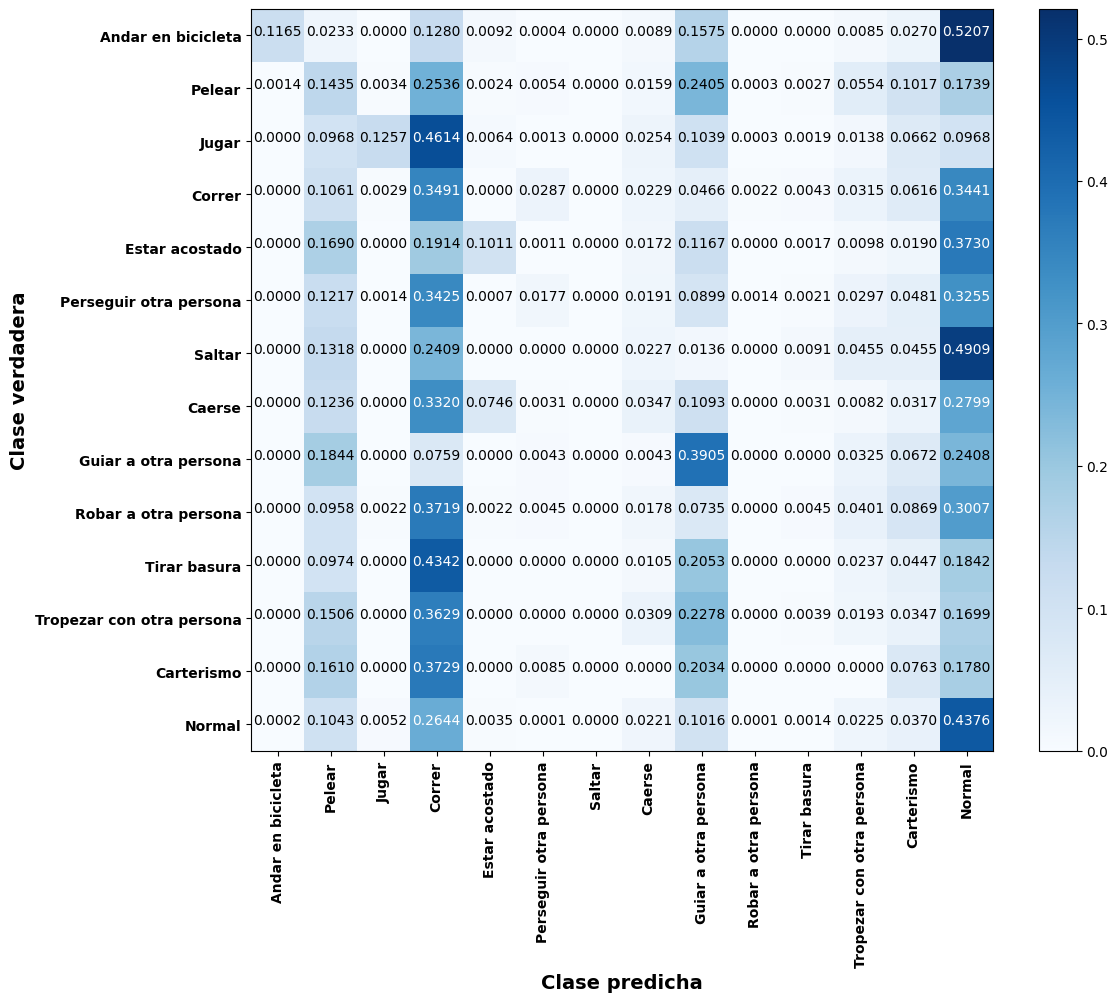

In [5]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()


In [6]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                            Event Mode  TP   FP  \
0    4_089_1                      a video of a person falling    3   9    3   
1    1_092_1                      a video of a person jumping    3   0    0   
2    2_082_1                     a video of a person tripping    3   0    2   
3    2_073_1                      a video of a person running    3   9  126   
4    2_090_1            a video of a group of persons playing    3   1    0   
..       ...                                              ...  ...  ..  ...   
168   000326             a video of a person riding a bicycle    3   2    0   
169  2_083_1         a video of a person chasing other person    3   2    0   
170  3_084_1  a video of a person throwing trash in the floor    3   0    0   
171   000325             a video of a person riding a bicycle    3   8    0   
172  2_087_1         a video of a person guiding other person    3  16    7   

      FN   TN  
0    140  291  
1     33   50  
2  

/tmp/ipykernel_154875/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6097560975609756 0.8283898305084746 1.0 0.6666666666666666
 0.9090909090909091 1.0 1.0 0.39950779327317476 0.5625 0.7142857142857143]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_154875/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.14353259034110097 0.1257234726688103 0.017692852087756547
 0.03472931562819203 0.39045553145336226 0.0 0.10114942528735632
 0.11649408284023668 0.34910394265232975 0.0 0.07627118644067797 0.0
 0.019305019305019305]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_154875/2034563803.py:25: Future

In [7]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingDevM4MC_Score.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

42.70320275657707 hours


['a video of a person riding a bicycle'
 'a video of a certain number of persons fighting'
 'a video of a group of persons playing' 'a video of a person running'
 'a video of a person lying in the floor'
 'a video of a person chasing other person' 'a video of a person jumping'
 'a video of a person falling' 'a video of a person guiding other person'
 'a video of a person stealing other person'
 'a video of a person throwing trash in the floor'
 'a video of a person tripping'
 "a video of a person stealing other person's pocket"]


       Process time
Mode              
3         1.263879


In [8]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values2 = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values2)

            AP
Mode          
3     0.253467


/tmp/ipykernel_154875/4034585013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.75 0.0 0.06666666666666667 1.0 0.7 1.0 1.0 0.6764705882352942 1.0
 0.5357142857142857 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.7391304347826086 0.875
 1.0 0.5434782608695652 0.5833333333333334 0.7857142857142857
 0.8823529411764706 0.6363636363636364 0.8125 0.2222222222222222
 0.8541666666666666 1.0 0.5227272727272727 1.0 1.0 0.043478260869565216
 0.3870967741935484 1.0 1.0 1.0 0.6923076923076923 0.5769230769230769
 0.7894736842105263 0.7916666666666666 1.0 0.40625 1.0 1.0 1.0 1.0
 0.6153846153846154 0.3333333333333333 1.0 0.5517241379310345
 0.21428571428571427 0.42857142857142855 0.0 0.4594594594594595 1.0 1.0
 0.23076923076923078 0.3 0.6206896551724138 0.07430340557275542
 0.22857142857142856 0.3076923076923077 0.6 1.0 0.9 0.5604395604395604
 0.631578947368421 1.0 0.782608695652174 1.0 1.0 0.8461538461538461
 0.4761904761904

In [9]:
print(df_sum)
print(mAP_values)
print("\n\n", mAP_values2)

     Precision    Recall  Accuracy        F1
Mode                                        
3     0.591554  0.105727  0.566664  0.156514
      Process time
Mode              
3         1.263879


             AP
Mode          
3     0.253467


In [10]:
order = [
    "Riding",
    "Playing", 
    "Guiding", 
    "Pickpockering",# Finish specific class events
    "Stealing",
    "Jumping",
    "Tripping",
    "Chasing",
    "Falling",
    "Lying",
    "Littering",
    "Running",
    "Fighting",
]

'''def reduce_to_one(selected_events, events_score, events_answer):
    
    for i in range(len(order)):
        if events_description[order[i]] in selected_events:
            return [events_description[order[i]]]
    # If no specific class is found, return the first event
def selection_events(events_score, events_answer, verbose=False):
    events_score.pop(PREFIX+normal_prompt)
    # Step 1: Find the maximum score
    max_score = max(events_score.values())
    # Step 2: Filter events that have the max score
    #top_events = [event for event, score in events_score.items() if score == max_score]
    top_events = [event for event, score in events_score.items() if score == max_score and events_answer[event] == "Yes"]
    # Result
    if max_score<threshold or len(top_events)==0:
        return [PREFIX+normal_prompt]
    if verbose:
        print("Max score:", max_score)
        print("Events with max score:", top_events)
    return top_events'''

normal_events=0
events_score = {}
events_answer = {}
print(len(all))
predictions_correct=0
rules_correct=0
events_count=0
several_events=0
reduced_correct=0
normal_count=0
errors_selected=0
normal_correct=0
events_dict={}
for i in range(len(order)):
    events_dict[events_description[order[i]]] = dict()
for event, prompt, predicted in all:
    if event== PREFIX+normal_prompt:
        normal_events+=1
    text=''
    text+= f'\n**Event: {event}**\n'
    selected_events= []
    if prompt == "":
        selected_events= [PREFIX+normal_prompt]
        if event in predicted:
            normal_correct+=1
    else:
        if event in predicted:
            rules_correct+=1
            verbose=True
        else:
            verbose=False
        verbose=False
        events_score = {}
        events_answer = {}
        for i in range(len(prompt)):
            # Extract "Yes" and "100" using capturing groups
            pattern = r'Answer:\s*(?:\[)?(.*?)(?:\])?\nScore:\s*(?:\[)?(\d+)(?:\])?'
            #print('Prompt:',prompts[i], '\nPredicted:',events[i],'\n')
            match = re.search(pattern, prompt[i])
            if match:
                answer = match.group(1)  # "Yes"
                score = int(match.group(2))  # 100 (converted to integer)
                events_score[predicted[i]] = score
                events_answer[predicted[i]] = answer
                #print(f'{j} Event:{events[j]}')
                text+= f"Answer: {answer}, Score: {score}, Event: {predicted[i]}\n"
        selected_events = selection_events(events_score, events_answer)
    text += f"**Selected events:** {selected_events}\n"
    if event in selected_events:
        predictions_correct+=1
    if event in selected_events and event!= PREFIX+normal_prompt:
        events_count+=1
    elif event in selected_events and event== PREFIX+normal_prompt:
        normal_count+=1
    elif event not in selected_events:
        errors_selected+=1
    if event in selected_events and event!= PREFIX+normal_prompt and len(selected_events) > 1:
        for i in range(len(selected_events)):
            if selected_events[i] not in events_dict[event]:
                events_dict[event][selected_events[i]] = 0
            events_dict[event][selected_events[i]] += 1
        several_events+=1
        selection=reduce_to_one(selected_events)
        text+= f"**Reduced to:** {selection[0]}\n"
        if selection[0]==event:
            text+= "Reduced correct\n"
            reduced_correct+=1
        #print(text)
print(f'\nRules predicted an event correct and normal: {rules_correct}/{len(all)} ({100*rules_correct/len(all):0.2f}%)')
print(f'Rules dont predicted, so is an normal event correct: {normal_correct}/{len(all)} ({100*normal_correct/len(all):0.2f}%)')
print(f'''{'-'*50}\n
Total ({100*(rules_correct+normal_correct)/len(all):0.2f}%)\nWhich:''')

print(f'Normal Frames: {normal_events}/{len(all)} ({100*normal_events/len(all):0.2f} %) Event Frames: {len(all)-normal_events}/{len(all)} ({100*(len(all)-normal_events)/len(all):0.2f} %)\n')
print('After selection:\n')
print(f'Event not in the selected events: {errors_selected}/{len(all)} ({100*errors_selected/len(all):0.2f} %)')
print(f'Event in the selected events: {predictions_correct}/{predictions_correct} ({100*predictions_correct/len(all):0.2f} %)\nWhich:')
print(f'Prediction of normal event in the selected events: {normal_count}/{predictions_correct} ({100*normal_count/predictions_correct:0.2f} %)')
print(f'Prediction of the event in the selected events: {events_count}/{predictions_correct} ({100*events_count/predictions_correct:0.2f} %)')
print('\nOf the events selected:')
print(f'Events selected corretly and just one option: {((events_count-several_events))}/{events_count} ({100*((events_count-several_events))/events_count:0.2f}%)') 
print(f'Events in the selected but several options: {several_events}/{events_count} ({100*several_events/events_count:0.2f}%)')
print(f'Events in the selected and selected correct: {reduced_correct}/{several_events} ({100*reduced_correct/several_events:0.2f}%)')
print(f'Events selected corretly: {(reduced_correct+(events_count-several_events))}/{events_count} ({100*(reduced_correct+(events_count-several_events))/events_count:0.2f}%)\n') 

if stored:
    rute_df="/home/ubuntu/Tesis/Storage/M4MulticlassNMS/DFS/DF_experiment.csv"
    row = {
        'Threshold': round(threshold, 4), 
        'Answer': answer_use, 
        'Event Not in Selected': round(100 * errors_selected / len(all), 4), 
        'Event in Selected': round(100 * predictions_correct / len(all), 4),
        'Prediction Normal Correct': round(100 * normal_count / predictions_correct, 4), 
        'Prediction Event Correct': round(100 * events_count / predictions_correct, 4),
        'AP': round(mAP_values2.AP.values[0], 4), 
        'Precision': round(df_sum.Precision.values[0], 4), 
        'Recall': round(df_sum.Recall.values[0], 4), 
        'F1': round(df_sum.F1.values[0], 4)
    }
    try:
        df_experiments=pd.read_csv(rute_df)
    except FileNotFoundError:
        df_experiments= pd.DataFrame(columns=['Threshold', 'Answer', 'Event Not in Selected',
        'Event in Selected', 'Prediction Normal Correct', 'Prediction Event Correct', 'AP', 'Precision', 'Recall', 'F1']) 

    df_experiments=pd.concat([df_experiments, pd.DataFrame([row])], ignore_index=True) 
    df_experiments.to_csv(rute_df, index=False)

32467

Rules predicted an event correct and normal: 20421/32467 (62.90%)
Rules dont predicted, so is an normal event correct: 2260/32467 (6.96%)
--------------------------------------------------

Total (69.86%)
Which:
Normal Frames: 16278/32467 (50.14 %) Event Frames: 16189/32467 (49.86 %)

After selection:

Event not in the selected events: 22742/32467 (70.05 %)
Event in the selected events: 9725/9725 (29.95 %)
Which:
Prediction of normal event in the selected events: 7123/9725 (73.24 %)
Prediction of the event in the selected events: 2602/9725 (26.76 %)

Of the events selected:
Events selected corretly and just one option: 1541/2602 (59.22%)
Events in the selected but several options: 1061/2602 (40.78%)
Events in the selected and selected correct: 506/1061 (47.69%)
Events selected corretly: 2047/2602 (78.67%)



In [11]:
print(count)
for i in range(len(order)):
    if events_description[order[i]] in events_dict:
        print(f"{order[i]}: {len(events_dict[events_description[order[i]]])} events")
        for key, value in events_dict[events_description[order[i]]].items():
            print(f"  {key}: {value}")

9725
Riding: 8 events
  a video of a person riding a bicycle: 94
  a video of a person running: 64
  a video of a person guiding other person: 23
  a video of a certain number of persons fighting: 18
  a video of a person stealing other person's pocket: 10
  a video of a person tripping: 3
  a video of a person lying in the floor: 6
  a video of a person chasing other person: 2
Playing: 8 events
  a video of a group of persons playing: 171
  a video of a person guiding other person: 43
  a video of a person running: 109
  a video of a person stealing other person's pocket: 14
  a video of a certain number of persons fighting: 27
  a video of a person falling: 3
  a video of a person chasing other person: 5
  a video of a person tripping: 3
Guiding: 6 events
  a video of a person running: 31
  a video of a person guiding other person: 109
  a video of a certain number of persons fighting: 71
  a video of a person stealing other person's pocket: 29
  a video of a person tripping: 17
  a 